# Veri Seti Tanıtımı
Link: https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste

Veri seti, deniz canlılarının farklı görüntülerini içerir. Bazı görseller pixabay.com'dan alınmıştır ve kullanıldığında herhangi bir lisans veya atıf gerektirmez. Diğer görüntüler flickr.com'dan alınmıştır ve ticari olarak derinlemesine kullanıldığında orijinal yazarlara atıfta bulunulması gerekecektir.

Deniz canlılarının sınıflandırılması ile, tehdit altındaki türlerin takibi, ekosistem değişikliklerini izleme ve bilimsel araştırmalar gibi özellikle hayvan takibi gerektiren su altı çalışmalarına fayda sağlanabilir.

Görüntüler (300px, n) veya (n, 300px) olarak yeniden boyutlandırılmıştır; Burada n, 300px'den küçük bir piksel boyutudur.
Toplamda 23 sınıftan oluşmaktadır:

1. Penguen (Penguin)  
2. Midyeler (Clams)  
3. Istakoz (Lobster)  
4. Su samuru (Otter)  
5. Yılan balığı (Eel)  
6. Mercanlar (Corals)  
7. Kirpi balıkları (Puffers)  
8. Kalamar (Squid)  
9. Balina (Whale)  
10. Deniz kestaneleri (Sea Urchins)  
11. Yengeçler (Crabs)  
12. Deniz yıldızı (Starfish)  
13. Fok (Seal)  
14. Ahtapot (Octopus)  
15. Karides (Shrimp)  
16. Köpek balıkları (Sharks)  
17. Vatozlar (Sea Rays)  
18. Balık (Fish)  
19. Denizatı (Seahorse)  
20. Deniz tavşanları (Nudibranchs)  
21. Yunus (Dolphin)  
22. Kaplumbağa / Tosbağa (Turtle_Tortoise)  
23. Denizanası (Jelly Fish)

In [1]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# --- Configuration ---
dataset_dir = './archive'  # Dataset path
output_dir = './sea animals'    # Where to save the split dataset
split_ratio = [0.75, 0.1, 0.15]   # Train, Val, Test split
random.seed(42)

# --- Create output folders ---
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a folder
            os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# --- Process each class folder ---
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        continue

    # Split into train, val, and test
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - split_ratio[0]), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=42)

    # Copy files to respective folders
    for img_name in train_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'train', class_name, img_name))
    for img_name in val_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'val', class_name, img_name))
    for img_name in test_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'test', class_name, img_name))

print("Dataset split completed successfully!")

Dataset split completed successfully!


In [2]:
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

INPUT_SIZE = (300, 300)

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "sea animals/train",
    shuffle=True,
    image_size=INPUT_SIZE,
    label_mode='int'  # labels as indices
)
# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "sea animals/val",
    shuffle=False,
    image_size=INPUT_SIZE,
    label_mode='int'
)
# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    "sea animals/test",
    shuffle=False,
    image_size=INPUT_SIZE,
    label_mode='int'
)

Found 10275 files belonging to 23 classes.
Found 1369 files belonging to 23 classes.
Found 2067 files belonging to 23 classes.


In [2]:
preprocess = tf.keras.Sequential([  layers.Rescaling(1./255)])

In [23]:
base_model = tf.keras.applications.EfficientNetB3(
weights='imagenet',
include_top=False,
input_shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3)
)
for layer in base_model.layers[:len(base_model.layers)-4]:
    layer.trainable = False

![EfficientNetB3](https://www.researchgate.net/publication/359449935/figure/fig2/AS:1179981350744115@1658340885857/Schematic-representation-of-EfficientNet-B3.png)

In [32]:
inputs = base_model.input
x = preprocess(inputs)
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(23, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # SparseCategoricalAccuracy

model.summary()

In [34]:
checkpoint_path = "./checkpoints/efficientnetb3_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True)

In [ ]:
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=25,
callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 91s 229ms/step - accuracy: 0.4807 - loss: 2.0840 - val_accuracy: 0.8269 - val_loss: 0.7217
Epoch 2/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 185ms/step - accuracy: 0.8180 - loss: 0.7486 - val_accuracy: 0.8532 - val_loss: 0.5517
Epoch 3/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 186ms/step - accuracy: 0.8444 - loss: 0.5818 - val_accuracy: 0.8576 - val_loss: 0.5088
Epoch 4/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 185ms/step - accuracy: 0.8596 - loss: 0.5072 - val_accuracy: 0.8634 - val_loss: 0.4858
Epoch 5/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step - accuracy: 0.8719 - loss: 0.4703 - val_accuracy: 0.8641 - val_loss: 0.4715
Epoch 6/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 186ms/step - accuracy: 0.8839 - loss: 0.4264 - val_accuracy: 0.8663 - val_loss: 0.4594
Epoch 7/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 186ms/step - accuracy: 0.8950 - loss: 0.3921 - val_accuracy: 0.8700 - val_loss: 0.4520
Epoch 8/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.8975 - loss: 0.3650 - val_accuracy: 0.8685 - val_loss: 0.4459
Epoch 9/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step - accuracy: 0.9053 - loss: 0.3388 - val_accuracy: 0.8722 - val_loss: 0.4412
Epoch 10/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.9116 - loss: 0.3176 - val_accuracy: 0.8700 - val_loss: 0.4440
Epoch 11/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 186ms/step - accuracy: 0.9168 - loss: 0.3041 - val_accuracy: 0.8729 - val_loss: 0.4396
Epoch 12/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.9206 - loss: 0.2778 - val_accuracy: 0.8714 - val_loss: 0.4385
Epoch 13/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9230 - loss: 0.2713 - val_accuracy: 0.8729 - val_loss: 0.4413
Epoch 14/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step - accuracy: 0.9273 - loss: 0.2567 - val_accuracy: 0.8744 - val_loss: 0.4378
Epoch 15/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9328 - loss: 0.2369 - val_accuracy: 0.8729 - val_loss: 0.4369
Epoch 16/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 186ms/step - accuracy: 0.9386 - loss: 0.2258 - val_accuracy: 0.8795 - val_loss: 0.4397
Epoch 17/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9386 - loss: 0.2182 - val_accuracy: 0.8766 - val_loss: 0.4337
Epoch 18/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 60s 186ms/step - accuracy: 0.9396 - loss: 0.1971 - val_accuracy: 0.8839 - val_loss: 0.4357
Epoch 19/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.9481 - loss: 0.1858 - val_accuracy: 0.8802 - val_loss: 0.4355
Epoch 20/25


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 184ms/step - accuracy: 0.9481 - loss: 0.1872 - val_accuracy: 0.8780 - val_loss: 0.4526


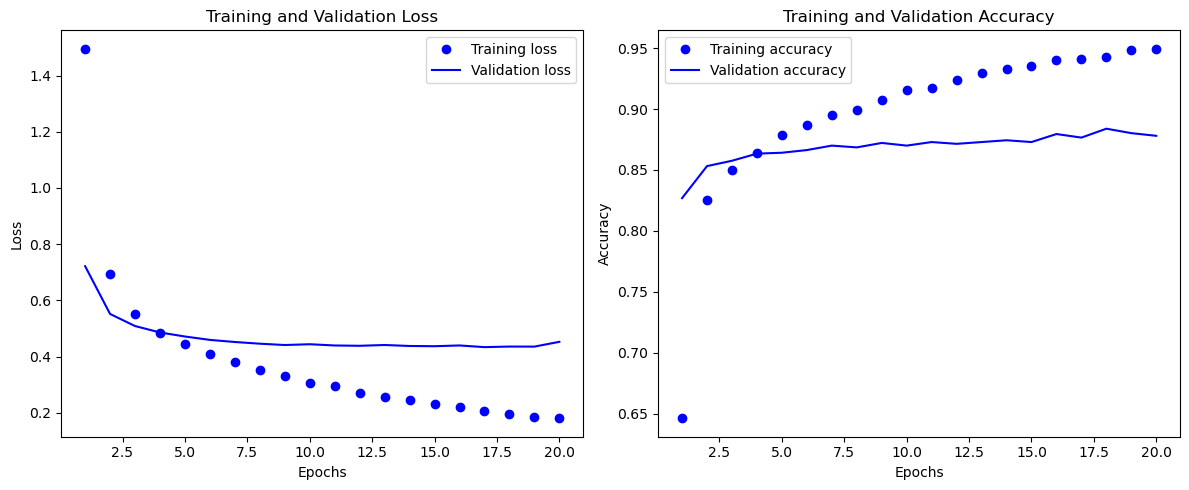

In [36]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
ax1.plot(epochs, loss_values, 'bo', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Accuracy
ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [37]:
loss, accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)

65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.8557 - loss: 0.5542
Loss: 0.4153333604335785
Accuracy: 0.8853965401649475


# Grad-Cam Visualization

In [38]:
import numpy as np
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (INPUT_SIZE[0], INPUT_SIZE[1], 3)
# Remove last layer's softmax
model.layers[-1].activation = None

In [39]:
import pandas as pd
import os

# Path to your dataset
test_dir = "./sea animals/test"

# Get class names (these will be used as labels)
class_names = test_ds.class_names

# Initialize lists to store the image data, labels, and file paths
images = []
image_paths = []

# Function to load image paths and corresponding labels
def load_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    
    # Iterate through the directory structure to gather file paths and labels
    class_names = os.listdir(directory)
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust image types if necessary
                    image_paths.append(os.path.join(class_path, filename))
                    labels.append(class_name)  # Append the class name instead of index
    
    return image_paths, labels

# Get image paths and labels
image_paths, labels = load_image_paths_and_labels(test_dir)

# Iterate through the dataset to extract image data
for image_batch, _ in test_ds:
    images.append(image_batch.numpy())

# Flatten the images and convert to a single array
images = np.vstack(images).reshape(-1, np.prod(INPUT_SIZE) * 3)  # Flatten to 1D for each image

# Create a DataFrame with images, class names as labels, and file paths
test_df = pd.DataFrame(images)
test_df['label'] = labels
test_df['filepath'] = image_paths

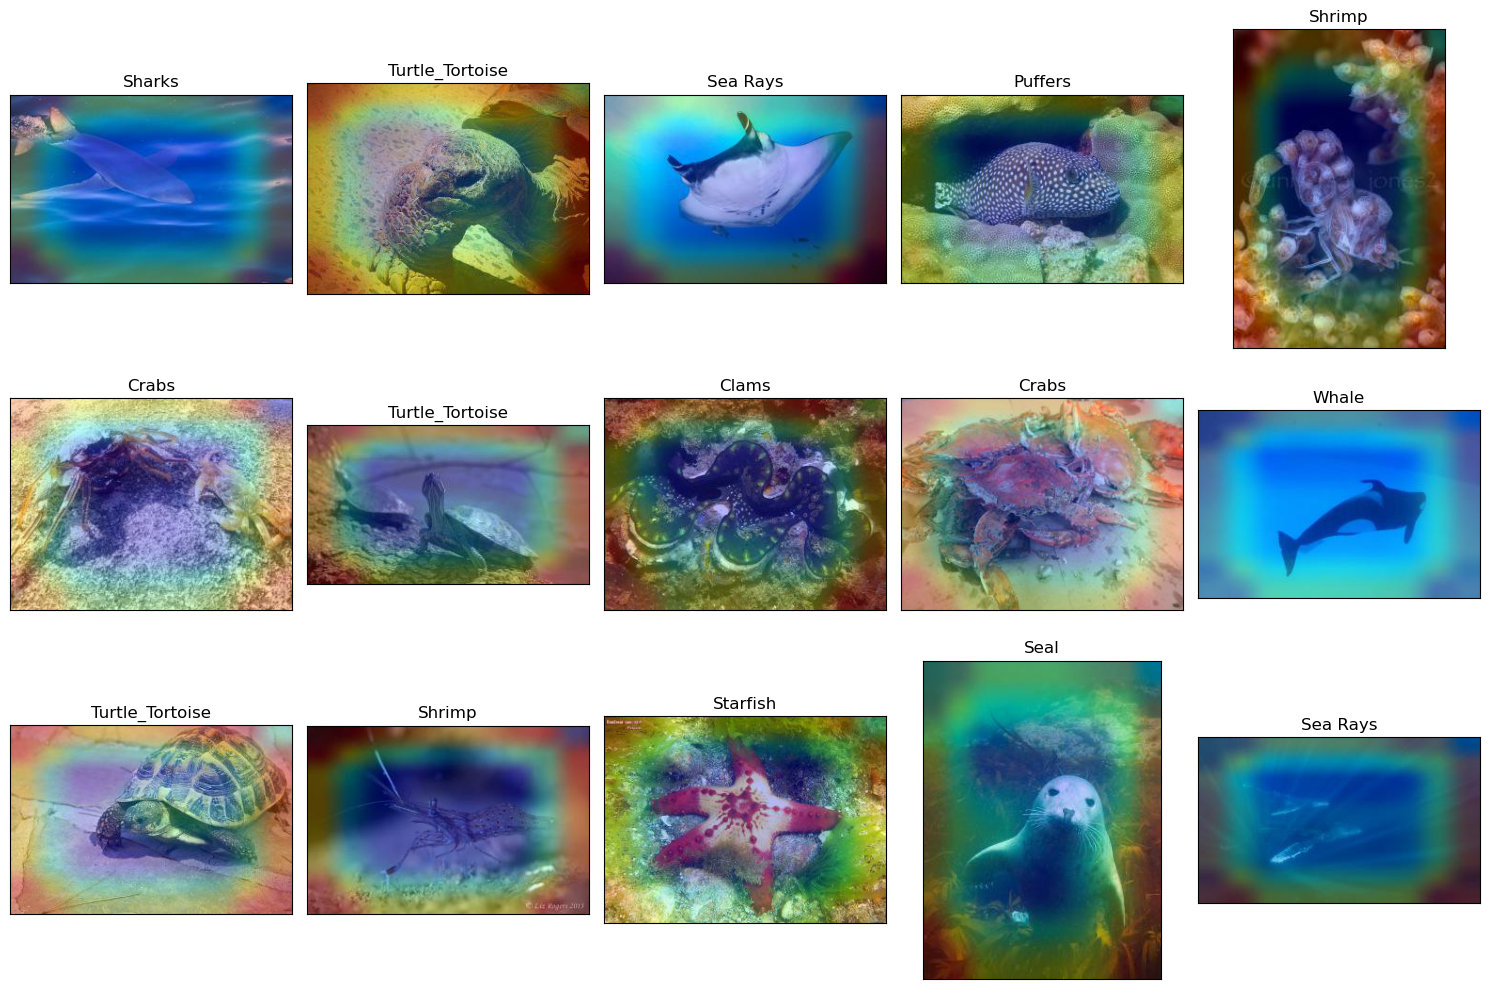

In [40]:
random_index = np.random.randint(0, len(test_df), 16)
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df['filepath'].iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(test_df['label'].iloc[random_index[i]])
plt.tight_layout()
plt.show()

os.remove("cam.jpg")

In [1]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# --- Configuration ---
dataset_dir = r"C:\Users\afyon\OneDrive\Desktop\dataset"  # Dataset path
output_dir = './sea animals'    # Where to save the split dataset
split_ratio = [0.75, 0.1, 0.15]   # Train, Val, Test split
random.seed(42)

# --- Create output folders ---
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a folder
            os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# --- Process each class folder ---
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        continue

    # Split into train, val, and test
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - split_ratio[0]), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=42)

    # Copy files to respective folders
    for img_name in train_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'train', class_name, img_name))
    for img_name in val_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'val', class_name, img_name))
    for img_name in test_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'test', class_name, img_name))

print("Dataset split completed successfully!")

Dataset split completed successfully!


In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint


INPUT_SIZE = (128, 128)  # daha hafif boyut
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE


# Load train dataset
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\afyon\OneDrive\Desktop\dataset\train",
    shuffle=True,
    image_size=INPUT_SIZE,
    label_mode='int',
    batch_size=BATCH_SIZE
)
train_class_names = train_ds_raw.class_names
train_ds = train_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

# Load validation dataset
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\afyon\OneDrive\Desktop\dataset\validation",
    shuffle=False,
    image_size=INPUT_SIZE,
    label_mode='int',
    batch_size=BATCH_SIZE
)
val_class_names = val_ds_raw.class_names
val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

# Load test dataset
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\afyon\OneDrive\Desktop\dataset\test",
    shuffle=False,
    image_size=INPUT_SIZE,
    label_mode='int',
    batch_size=BATCH_SIZE
)
test_class_names = test_ds_raw.class_names
test_ds = test_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)



Found 10961 files belonging to 23 classes.
Found 1370 files belonging to 23 classes.
Found 1380 files belonging to 23 classes.


In [3]:
preprocess = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [4]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3)
)

In [5]:
for layer in base_model.layers[:-10]:
    layer.trainable = False


In [6]:
inputs = base_model.input
x = preprocess(inputs)
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(23, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,8

 Total params: 14,749,015 (56.26 MB)

 Trainable params: 13,603,607 (51.89 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [ ]:
checkpoint_path = "vgg16_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint( checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True )
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True)

In [ ]:
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=10,
callbacks=[ early_stopping, checkpoint_callback ]
)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 966s 11s/step - accuracy: 0.1006 - loss: 20.3246 - val_accuracy: 0.1387 - val_loss: 3.0401
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 534s 6s/step - accuracy: 0.1398 - loss: 3.0096 - val_accuracy: 0.1547 - val_loss: 2.8337
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 556s 6s/step - accuracy: 0.1734 - loss: 2.7779 - val_accuracy: 0.2496 - val_loss: 2.4615
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 559s 7s/step - accuracy: 0.2685 - loss: 2.4255 - val_accuracy: 0.3241 - val_loss: 2.2524
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 578s 7s/step - accuracy: 0.3145 - loss: 2.2414 - val_accuracy: 0.3511 - val_loss: 2.1161
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 578s 7s/step - accuracy: 0.3515 - loss: 2.0936 - val_accuracy: 0.3496 - val_loss: 2.1371
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 580s 7s/step - accuracy: 0.3709 - loss: 2.0450 - val_accuracy: 0.3956 - val_loss: 2.0134
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 583s 7s/step - accuracy: 0.4012 - loss: 1.9320 - val_accuracy: 0.4168 -

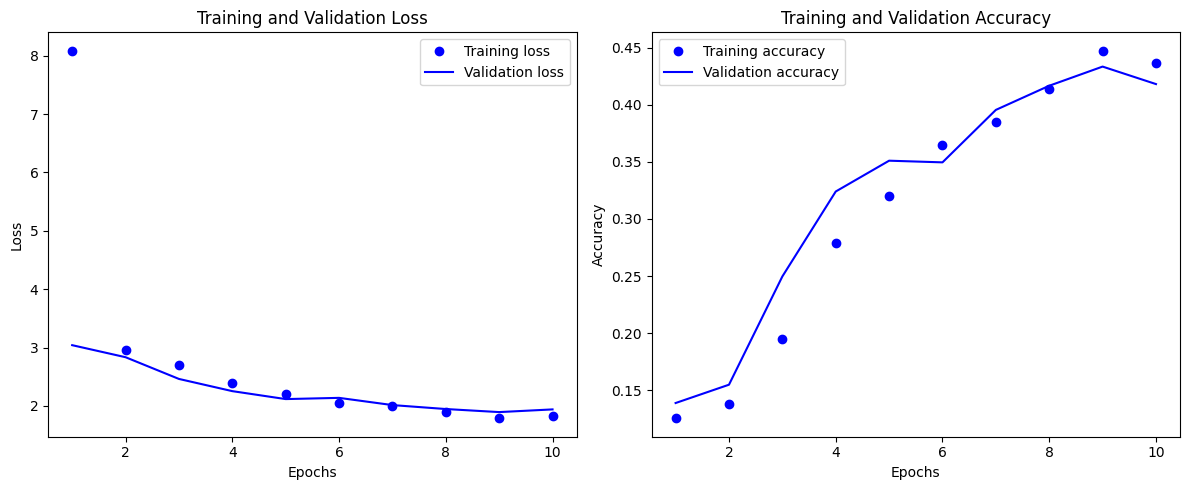

In [10]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
ax1.plot(epochs, loss_values, 'bo', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Accuracy
ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.4001 - loss: 1.9705
Loss: 1.8054699897766113
Accuracy: 0.43405798077583313


In [ ]:
import numpy as np
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "block5_conv3"
img_size = (INPUT_SIZE[0], INPUT_SIZE[1], 3)
# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing import image

# Parametreler
INPUT_SIZE = (128, 128)
test_dir = r"C:\Users\afyon\OneDrive\Desktop\dataset\test"

# Class isimlerini dizinden al
class_names = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])

# Dosya yollarını ve etiketlerini topla
def load_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, filename))
                labels.append(class_name)
    
    return image_paths, labels

image_paths, labels = load_image_paths_and_labels(test_dir)

# Görselleri oku ve normalize et (0-1)
def load_and_preprocess_image(path):
    img = image.load_img(path, target_size=INPUT_SIZE)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Görselleri yükle
images = np.array([load_and_preprocess_image(p) for p in image_paths])

# Görselleri düzleştir (flatten)
images_flat = images.reshape(images.shape[0], -1)

# DataFrame oluştur
test_df = pd.DataFrame(images_flat)
test_df['label'] = labels
test_df['filepath'] = image_paths

print(test_df.head())


          0         1         2         3         4         5         6  \
0  0.137255  0.254902  0.223529  0.196078  0.329412  0.337255  0.172549   
1  0.231373  0.372549  0.325490  0.215686  0.333333  0.301961  0.239216   
2  0.000000  0.482353  0.615686  0.019608  0.560784  0.745098  0.219608   
3  0.227451  0.384314  0.384314  0.227451  0.376471  0.380392  0.215686   
4  0.592157  0.580392  0.364706  0.149020  0.117647  0.043137  0.215686   

          7         8         9  ...     49144     49145     49146     49147  \
0  0.341176  0.368627  0.129412  ...  0.631373  0.482353  0.556863  0.662745   
1  0.341176  0.337255  0.160784  ...  0.564706  0.607843  0.549020  0.764706   
2  0.823529  1.000000  0.121569  ...  0.764706  0.882353  0.113725  0.792157   
3  0.364706  0.368627  0.203922  ...  0.466667  0.470588  0.356863  0.490196   
4  0.215686  0.207843  0.145098  ...  0.564706  0.521569  0.376471  0.364706   

      49148     49149     49150     49151  label  \
0  0.494118  0.5

C:\Users\afyon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)
C:\Users\afyon\AppData\Local\Temp\ipykernel_12848\3395012277.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


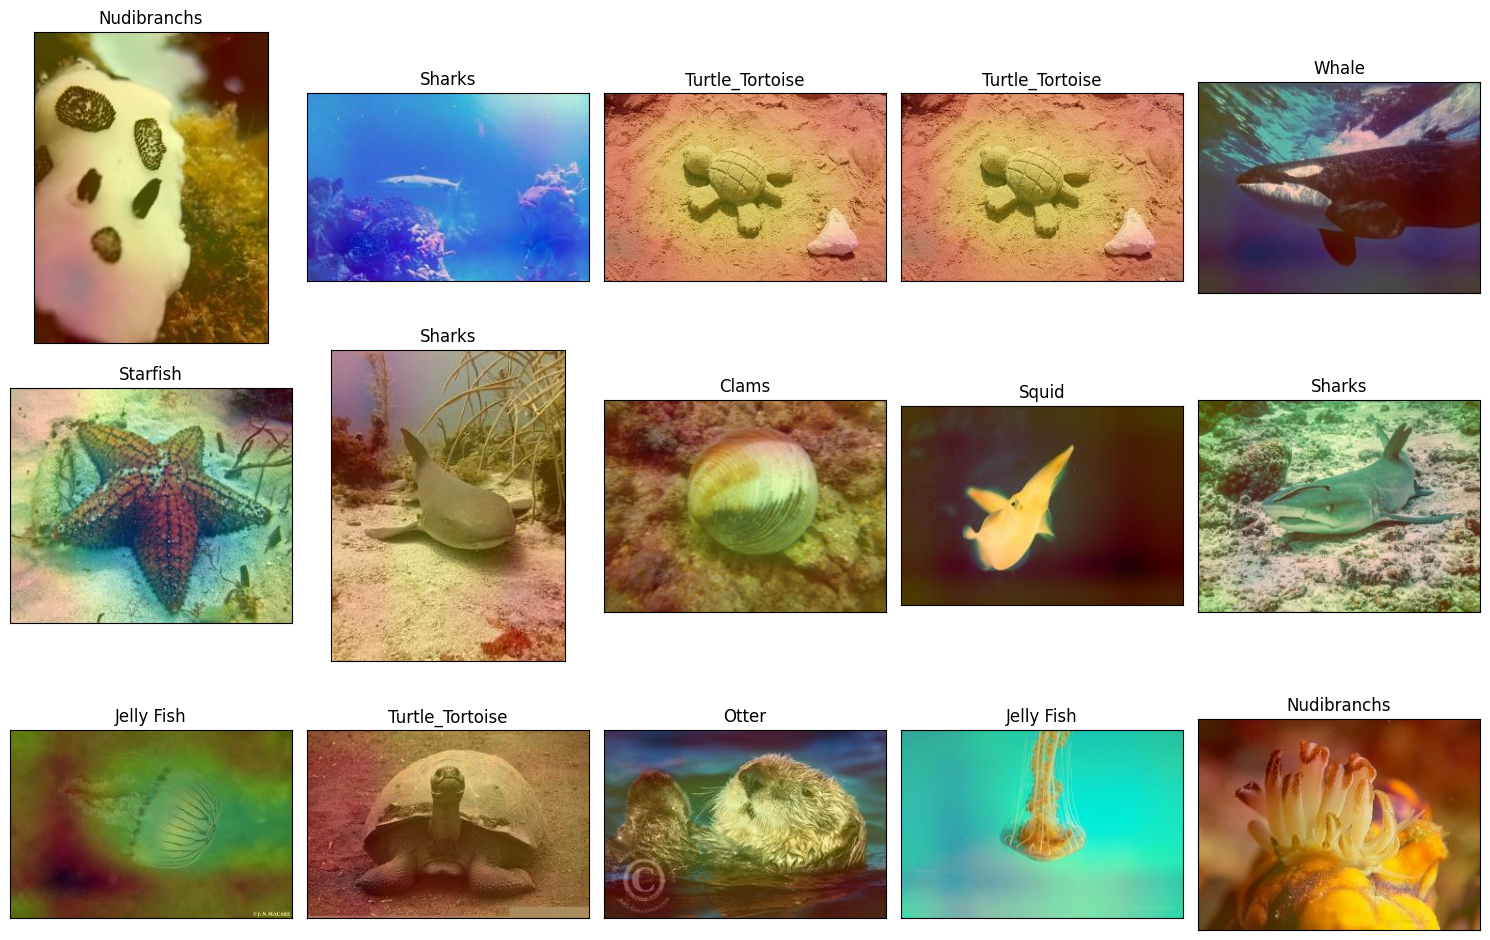

In [ ]:
random_index = np.random.randint(0, len(test_df), 15)  # 3x5 grid için 15 resim
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df['filepath'].iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(test_df['label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

os.remove("cam.jpg")

## Custom Model

Bu model, 4 adet Conv2D bloğundan oluşur. Her blok sonrası BatchNormalization ve MaxPooling uygulanır.

- Girdi boyutu: 300x300x3
- Aktivasyon: Swish (ReLU'ya göre daha iyi performans)
- BatchNormalization: Katman çıktılarının dağılımını normalize ederek öğrenmeyi hızlandırır ve modelin genelleme kabiliyetini artırır.
- MaxPooling: Özellik haritalarının boyutunu azaltarak bilgi yoğunluğunu artırır ve hesaplama yükünü düşürür.
- Dense Katmanlar: `128 → 64` yapılandırması ile sınıflandırma başlığı oluşturulmuştur.
- Çıkış: Softmax ile 23 sınıf

In [ ]:
from tensorflow.keras import layers, models

NUM_CLASSES = len(train_ds.class_names)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(300, 300, 3)),

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='swish', padding='same'),
    layers.BatchNormalization(),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='swish', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='swish', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Conv Block 4
    layers.Conv2D(256, (3, 3), activation='swish', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    # Transition to Dense
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),

    layers.Dense(64, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),

    layers.Dense(NUM_CLASSES, activation='softmax')
])


### Custom Model Eğitimi

- `Adam` optimizörü kullanıldı
- Kayıp fonksiyonu: `sparse_categorical_crossentropy`
- Epoch sayısı: 30
- `beta_1`, geçmiş gradyanlara ağırlık vererek momentum etkisi sağlar
- Her epoch sonunda `.keras` formatında checkpoint kaydı yapılıyor.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = ModelCheckpoint(
    filepath='/content/drive/MyDrive/sea_animals_project/checkpoints/custom_cnn_epoch{epoch:02d}.keras',
    save_weights_only=False,
    monitor='accuracy',        
    save_best_only=False,
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor='loss',             
    patience=4,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=30,
    callbacks=[checkpoint_cb, early_stopping_cb]
)


### Custom Model Değerlendirmesi

- En iyi kayıtlı model (`epoch 30`) yüklenerek test verisi üzerinde değerlendirildi.
- **Test Accuracy**: %71.12  
- **Test Loss**: 0.9973
    değerleri alındı.

In [5]:
from tensorflow.keras.models import load_model

custom_model = load_model('checkpoints/custom_cnn_epoch30.keras')

test_loss, test_acc = custom_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6574 - loss: 1.1501
Test Accuracy: 71.12%
Test Loss: 0.9973
